In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})

In [4]:
df = pd.read_csv('collated_results.csv')

In [5]:
df_filtered = df[~df['model_name'].str.contains('bugged', case=False, na=False)]

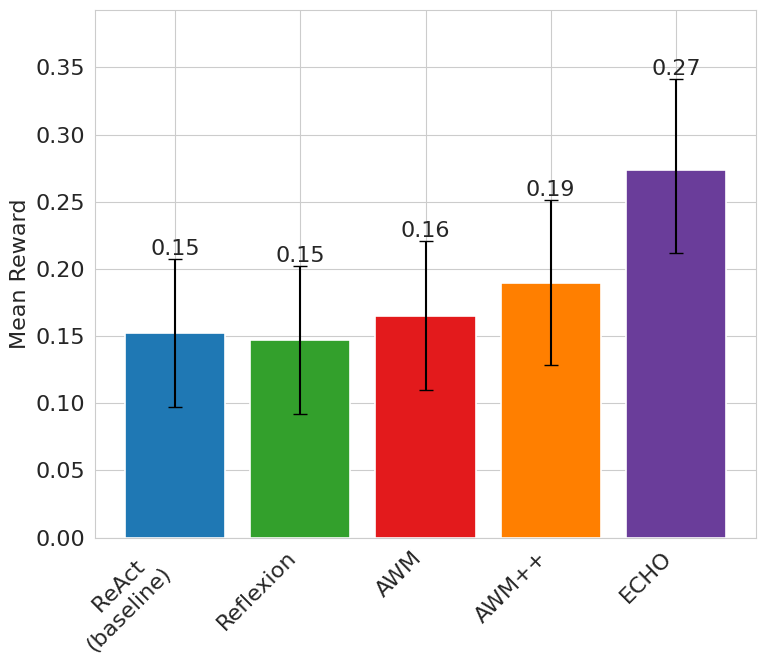

In [ ]:
# Filter to environments 6-16
df_filtered = df[df['environment'].between(6, 16)]

# Bootstrap function to calculate confidence intervals
def bootstrap_ci(data, n_bootstrap=6400, confidence=0.95):
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))

    alpha = 1 - confidence
    lower = np.percentile(bootstrap_means, (alpha / 2) * 100)
    upper = np.percentile(bootstrap_means, (1 - alpha / 2) * 100)
    return lower, upper

# --- Code with requested change ---

# Set the visual style
sns.set_style('whitegrid')

method_order = ['none', 'reflexion', 'awm', 'awmpp', 'echo']
rename_map = {
    'none': 'ReAct  \n(baseline)',
    'awm': 'AWM',
    'awmpp': 'AWM++',
    'reflexion': 'Reflexion',
    'echo': 'ECHO',
    'idealized': 'Upper Bound' # hand written prompts
}

# Use paired colormap but only take the darker colors (2nd in each pair)
paired_colors = sns.color_palette('Paired', len(method_order) * 2)
colors = [paired_colors[i * 2 + 1] for i in range(len(method_order))]

# Calculate confidence intervals for each method
ci_data = []
for method in method_order:
    method_data = df_filtered[df_filtered['method_name'] == method]['reward']
    if not method_data.empty:
        lower, upper = bootstrap_ci(method_data.values)
        mean_reward = method_data.mean()
        ci_data.append({
            'method': rename_map[method],
            'mean': mean_reward,
            'ci_lower': lower,
            'ci_upper': upper,
            'error_lower': mean_reward - lower,
            'error_upper': upper - mean_reward
        })

# Create the plot
plt.figure(figsize=(8, 7))

methods = [d['method'] for d in ci_data]
means = [d['mean'] for d in ci_data]
error_lower = [d['error_lower'] for d in ci_data]
error_upper = [d['error_upper'] for d in ci_data]

bars = plt.bar(methods, means, color=colors,
               yerr=[error_lower, error_upper], capsize=5,
               linewidth=1.2)

# Add value labels just above the 95% CI
for i, bar in enumerate(bars):
    # Get the mean value and the upper CI limit for positioning
    mean_val = ci_data[i]['mean']
    upper_ci = ci_data[i]['ci_upper']

    # Position the text slightly above the top of the error bar
    plt.text(bar.get_x() + bar.get_width() / 2, upper_ci, f"{mean_val:.2f}",
             ha='center', va='bottom', fontsize=16)

# --- Improved aesthetics ---
plt.ylabel('Mean Reward', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)

# Adjust Y-axis to ensure labels fit
max_y_limit = max([d['ci_upper'] for d in ci_data])
plt.ylim(0, max_y_limit * 1.15)

plt.tight_layout()
plt.savefig('plot_with_adjusted_labels.png')

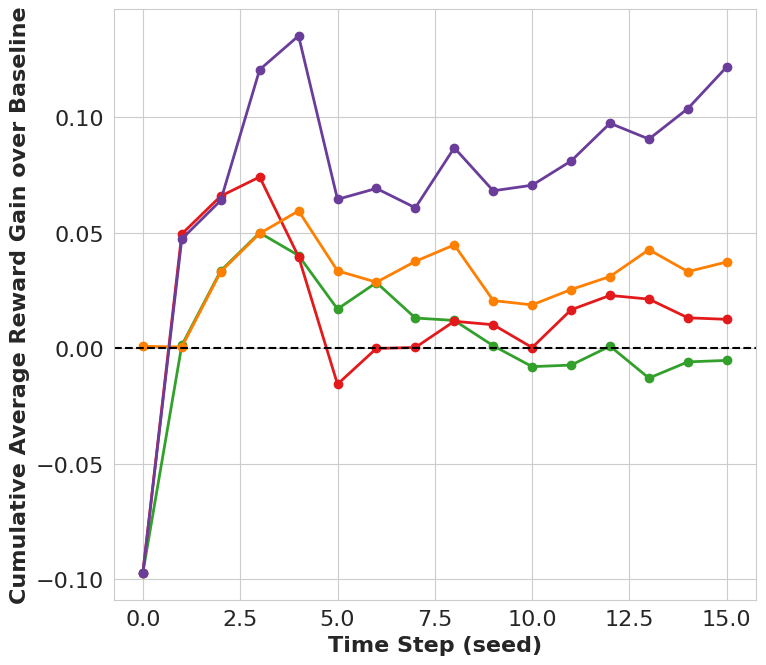

In [26]:
# Calculate baseline performance for each environment-seed combination
baseline_data = df_filtered[df_filtered['method_name'] == 'none'].groupby(['environment', 'seed'])['reward'].mean().reset_index()
baseline_data = baseline_data.rename(columns={'reward': 'baseline_reward'})

# Merge baseline with all methods
df_with_baseline = df_filtered.merge(baseline_data, on=['environment', 'seed'], how='left')

# Calculate reward gain for each method
df_with_baseline['reward_gain'] = df_with_baseline['reward'] - df_with_baseline['baseline_reward']

# Calculate average reward gain per method-seed across all environments
df_gain_by_seed = df_with_baseline.groupby(['method_name', 'seed'])['reward_gain'].mean().reset_index()

# Calculate cumulative average gain over time (seeds) for each method
methods_to_plot = ['reflexion', 'awm', 'awmpp', 'echo']

plt.figure(figsize=(8, 7))

# Define consistent colors and names
rename_map = {
    'reflexion': 'Reflexion',
    'awmpp': 'AWM++',
    'awm': 'AWM',
    'echo': 'ECHO',
    'echo-filtration': 'ECHO++',
    'echo-idealized': 'Upper Bound'
}
colors = sns.color_palette('Paired', len(methods_to_plot)  * 2 + 2 )[3::2]  # Skip the first color (green)
color_map = {method: color for method, color in zip(methods_to_plot, colors)}

# Plot cumulative average gain for each method
for method in methods_to_plot:
    method_data = df_gain_by_seed[df_gain_by_seed['method_name'] == method].sort_values('seed')
    
    if not method_data.empty:
        # Calculate cumulative average gain over time steps
        cumulative_gain = method_data['reward_gain'].expanding().mean()
        
        plt.plot(method_data['seed'], cumulative_gain, marker='o', linestyle='-',
                 label=rename_map.get(method, method),
                 color=color_map[method],
                 linewidth=2, markersize=6)

# Add reference line and styled labels/title
plt.axhline(0, color='black', linestyle='--', linewidth=1.5, label='Baseline')

plt.xlabel('Time Step (seed)', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative Average Reward Gain over Baseline', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('cumulative_gain_plot.png')
plt.show()